In [48]:
import cv2
import geopandas as gpd
import geoplot as gplt
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

from setup import *
from dataloader import load_demo, load_aggregate_travel_behavior
import util_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
data_version = '1571'
demo_cs, demo_np = load_demo(data_dir, norm='minmax')
file = "origin_trip_behavior.csv"
trip = load_aggregate_travel_behavior(file, data_version=data_version)

demo = pd.DataFrame(demo_np, 
             columns=['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita'], index=demo_cs)

trip = trip[['geoid','active','auto','mas','pt','trpgen','area']].set_index('geoid')

df = pd.merge(demo, trip, left_index=True, right_index=True)
df['trip_rate'] = df['trpgen']/df['area']
df['pop_density'] = df['tot_population']/df['area']

geoid_lookup = pd.DataFrame(np.array([np.arange(len(df)), df.index.to_numpy()]).T, columns=['index','geoid'])

In [4]:
print(df.columns)

Index(['tot_population', 'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs',
       'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone', 'pct_col_grad',
       'avg_tt_to_work', 'inc_per_capita', 'active', 'auto', 'mas', 'pt',
       'trpgen', 'area', 'trip_rate', 'pop_density'],
      dtype='object')


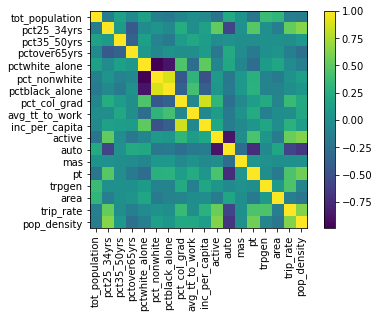

In [24]:
# Covariates
plt.imshow(df.corr().to_numpy());
plt.yticks(ticks=np.arange(len(df.columns)), labels=df.columns)
plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=90)

plt.colorbar();

In [29]:
model_type = 'SAE'
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '22021402'

clst = pd.read_csv(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+model_run_date+".csv")

df = df.merge(clst, left_index=True, right_on='geoid')
df.set_index('geoid', drop=False, inplace=True)

In [132]:
def find_similar(df, ct, sim, diff):
    sim_target = df.loc[ct, sim].to_numpy(dtype=float)
    diff_target = df.loc[ct, diff].to_numpy(dtype=float)
    
    sim = df[sim].to_numpy() - sim_target
    diff = df[diff].to_numpy() - diff_target
    
    sim = np.linalg.norm(sim, axis=1)
    diff = np.linalg.norm(diff, axis=1)

    diff = np.max(diff) - diff
    
#     srt = pd.DataFrame(sim, columns = ['sim'], index=df.index)
#     srt = srt.sort_values(by='sim')
#     srt = srt.reset_index(drop=False)
#     srt = srt.reset_index(drop=False)
#     srt['sim_index'] = srt['level_0']
    
#     srt2 = pd.DataFrame(diff, columns = ['diff'], index=df.index)
#     srt2 = srt2.sort_values(by='diff', ascending=False)
#     srt2 = srt2.reset_index(drop=False)
#     srt2 = srt2.reset_index(drop=False)
#     srt2['diff_index'] = srt2['level_0']

    
    srt = pd.DataFrame(np.array([sim, diff, df['kmeans'].to_numpy()]).T, columns=['sim','diff','kmeans'], index=df.index)
    
    srt['combined'] = srt['sim']+srt['diff']
    srt = srt.sort_values(by=['combined'])
    
    return srt[['combined','sim','diff','kmeans']]

In [26]:
def find_representative(df, sim, diff):
    sim_array = df[sim].to_numpy()
    diff_array = df[diff].to_numpy()
    
    sim_dist = pairwise_distances(sim_array, sim_array)
    diff_dist = pairwise_distances(diff_array, diff_array)

    diff_dist = np.max(diff_dist) - diff_dist
    
    dist = sim_dist + diff_dist
    
    dist_df = pd.DataFrame(np.array([dist.flatten(), sim_dist.flatten(), diff_dist.flatten()]).T, 
                           columns=['composite','sim','diff'])
    
    dist_df['tract_index1'] = np.unravel_index(dist_df.index.to_numpy(), (len(df), len(df)))[0]
    dist_df['tract_index2'] = np.unravel_index(dist_df.index.to_numpy(), (len(df), len(df)))[1]
    
    dist_df.sort_values(by='composite', inplace=True)    
    dist_df.drop_duplicates(subset=['composite','sim','diff'], inplace=True)

    return dist_df

In [243]:
# 'tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
# 'pctblack_alone',
# 'pct_col_grad','avg_tt_to_work','inc_per_capita'
# 'active','auto','mas','pt','trip_rate','pop_density'

dist = find_representative(df, sim=['inc_per_capita','pop_density'], 
                           diff=['active'])

In [244]:
dist = pd.merge(dist, geoid_lookup, left_on='tract_index1', right_on='index')
dist = pd.merge(dist, geoid_lookup, left_on='tract_index2', right_on='index')

In [245]:
dist = dist[(dist['geoid_x']!="17_89_851301")&(dist['geoid_y']!="17_89_851301")]

In [246]:
dist = pd.merge(dist, clst, left_on='geoid_x', right_on='geoid')
dist = pd.merge(dist, clst, left_on='geoid_y', right_on='geoid')

dist = dist[['composite','sim','diff','geoid_x','geoid_y','kmeans_x','kmeans_y']].sort_values(by='composite')

In [247]:
dist.head(10)

,composite,sim,diff,geoid_x,geoid_x,geoid_y,geoid_y,kmeans_x,kmeans_y
500625,0.056931,0.021676,0.035255,17_31_190300,17_31_190300,17_31_220902,17_31_220902,3,1
500626,0.064543,0.029287,0.035255,17_31_140500,17_31_140500,17_31_220902,17_31_220902,3,1
110765,0.084583,0.022037,0.062546,17_31_10503,17_31_10503,17_31_140500,17_31_140500,3,3
1447362,0.087275,0.027199,0.060076,17_31_842100,17_31_842100,17_97_862402,17_97_862402,2,3
500631,0.088560,0.029424,0.059135,17_31_151100,17_31_151100,17_31_220902,17_31_220902,3,1
482766,0.089586,0.029510,0.060076,17_97_861303,17_97_861303,17_31_842100,17_31_842100,0,2
496963,0.090724,0.029839,0.060885,17_31_190300,17_31_190300,17_31_310500,17_31_310500,3,3
154215,0.092250,0.044213,0.048037,17_31_220902,17_31_220902,17_31_140302,17_31_140302,1,3
110767,0.093940,0.033055,0.060885,17_31_310500,17_31_310500,17_31_140500,17_31_140500,3,3
496965,0.093940,0.033055,0.060885,17_31_140500,17_31_140500,17_31_310500,17_31_310500,3,3


In [230]:
c1 = "17_89_851301"

In [233]:
similar = find_similar(df, c1, sim=['inc_per_capita','pop_density'], 
                           diff=['active'])

In [234]:
similar.head(10)

,combined,sim,diff,kmeans
geoid,,,,
17_31_804510,0.007583,0.007583,0.000000,3.0
17_31_814400,0.008039,0.008039,0.000000,3.0
17_31_430400,0.014139,0.014139,0.000000,2.0
17_31_837000,0.018735,0.018735,0.000000,2.0
17_31_835900,0.021214,0.021214,0.000000,2.0
17_31_630300,0.029039,0.029039,0.000000,3.0
17_31_710500,0.030712,0.030712,0.000000,2.0
17_31_826600,0.031853,0.031853,0.000000,2.0
17_31_231500,0.031898,0.031898,0.000000,2.0


In [270]:
# "17_31_808702" # northwestern university; a very different tract

# 
# c1 = "17_197_881800" # high auto 5
# c2 = "17_31_842100" # low auto 4

# c1 = "17_31_806003" # low pt 5
# c2 = "17_31_242500" # high pt 5

c1 = "17_197_881302" # low income 5
c2 = "17_31_800100" # high income 4

# c1 = "17_31_411200" # low density 4 
# c2 = "17_31_81100" # high density 4 

# c1 = "17_31_140500"
# c2 = "17_31_220902"

df.loc[[c1, c2], ['pop_density','inc_per_capita','auto','pt','active']].round(2)

,pop_density,inc_per_capita,auto,pt,active
geoid,,,,,
17_197_881302,0.03,0.1,1.0,0.0,0.0
17_31_800100,0.01,1.0,1.0,0.0,0.0


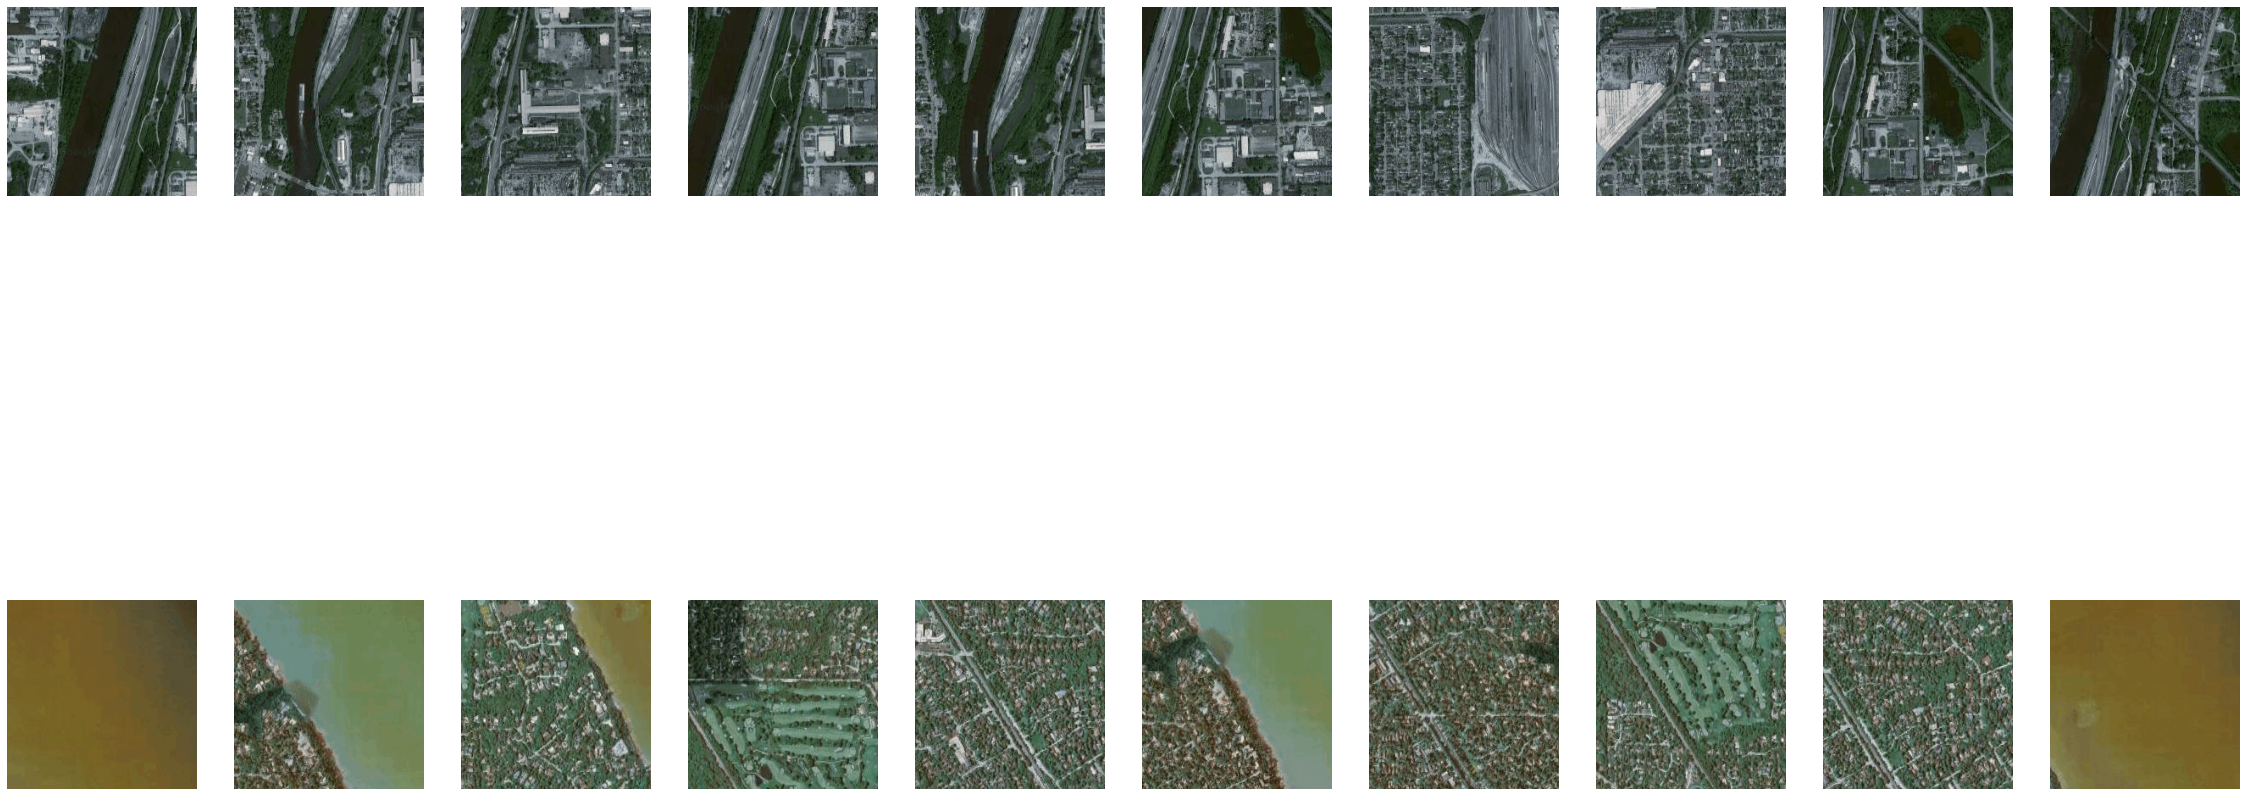

In [271]:
images1 = sorted(glob.glob(image_dir+"zoom15/"+c1+"_*.png"))
images2 = sorted(glob.glob(image_dir+"zoom15/"+c2+"_*.png"))

num_per_row = 10
fig, ax = plt.subplots(2,num_per_row,figsize=(num_per_row*4, num_per_row*2))
for i1, i2, i in zip(images1, images2, np.arange(num_per_row)):
    im = cv2.imread(i1)
    ax[0,i].imshow(util_image.center_crop(im, (224,224)))
    im = cv2.imread(i2)
    ax[1,i].imshow(util_image.center_crop(im, (224,224)))
    
    ax[0,i].axis('off')
    ax[1,i].axis('off')

plt.show()